# Explainer Notebook
Description of the explainer notebook.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('seaborn')
from IPython.display import HTML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

pd.set_option('display.max_columns', None)

# Motivation

In the section below, we will give a short introduction to our datasat along with a brief motivation of the topic.

Our dataset is the 'The Motor Vehicle Collisions' crash table which contains information from all police reported motor vehicle collisions in New York City (NYC), where each row represents a crash event. 
The data is collected from the following website: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95, where one can also read more about the history of data collection in New York Police Department (NYPD).

New York City is a vibrating and fast-moving city with over 8 mio. citizen, and we want to take a closer look into these collisions happening every day. More specificly to narrow the projects down a bit, we want to look into those collisions that result in injuries or deaths. 

In 2014 the Citywide traffic safety initiative, Vision Zero (https://www1.nyc.gov/content/visionzero/pages/), started, and their goal is to eliminate traffic fatalities. By using data analysis and vizualizations, our goal is to estimate when and where the probability of being injured or killed is highest, in order to work towards improving city traffic safety, and hopefull help reach Vision Zero's goal. We will in section *Genre* go more into details of our goals for the end user's experience. Our dataset contains necessary informations to reach our goal, with attributes such like time, location, the number of persons injured/killed and contributing factors of the collisions. 

# Basic Stats

In the following section we will take a closer look at the data and do a preliminary analysis to gain some insight into these collisions. 

## Preprocessing - Part 0: *Loading in the Data*

First thing first, we will load the dataset.

In [2]:
df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv'); df = df.loc[df['CRASH DATE'].apply(lambda x : (int(x[-4:]) > 2012)&(int(x[-4:]) < 2021))] #Only keep data from 2013 to 2020.
print(f'The shape of the data: {df.shape}')
df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of the data: (1644188, 29)


CRASH DATE CRASH TIME BOROUGH ZIP CODE  LATITUDE  LONGITUDE LOCATION  \
13   09/21/2014      21:16     NaN      NaN       NaN        NaN      NaN   
193  12/31/2020      16:30     NaN      NaN       NaN        NaN      NaN   
194  12/31/2020      18:07   BRONX  10462.0       NaN        NaN      NaN   
195  12/31/2020       8:45     NaN      NaN       NaN        NaN      NaN   
196  12/29/2020      15:00     NaN      NaN       NaN        NaN      NaN   

                       ON STREET NAME   CROSS STREET NAME OFF STREET NAME  \
13                                NaN                 NaN             NaN   
193  BELT PARKWAY                                     NaN             NaN   
194  CROSS BRONX EXPRESSWAY            CASTLE HILL AVENUE             NaN   
195  LONG ISLAND EXPRESSWAY                           NaN             NaN   
196  20 AVENUE                             PATRACCA PLACE             NaN   

     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
13                         2.0                       0.0   
193                        0.0                       0.0   
194                        0.0                       0.0   
195                        0.0                       0.0   
196                        0.0                       0.0   

     NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
13                               0                             0   
193                              0                             0   
194                              0                             0   
195                              0                             0   
196                              0                             0   

     NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
13                           0                         0   
193                          0                         0   
194                          0                         0   
195                          0                         0   
196                          0                         0   

     NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  \
13                            2                          0   
193                           0                          0   
194                           0                          0   
195                           0                          0   
196                           0                          0   

      CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
13                 Backing Unsafely                   Unspecified   
193  Reaction to Uninvolved Vehicle                           NaN   
194                     Unspecified                   Unspecified   
195            Unsafe Lane Changing                   Unspecified   
196           Following Too Closely                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
13                            NaN                           NaN   
193                           NaN                           NaN   
194                           NaN                           NaN   
195                           NaN                           NaN   
196                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
13                            NaN       3123558   
193                           NaN       4380668   
194                           NaN       4380840   
195                           NaN       4380675   
196                           NaN       4380010   

                     VEHICLE TYPE CODE 1 VEHICLE TYPE CODE 2  \
13                     PASSENGER VEHICLE   PASSENGER VEHICLE   
193                                Sedan                 NaN   
194  Station Wagon/Sport Utility Vehicle               Sedan   
195                                Sedan           Box Truck   
196                                Sedan               Sedan   

    VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  

The columns can be divided into several categories:

- **Temporal**
    - `CRASH DATE`
    - `CRASH TIME`
    
    
- **Spatial**
    - `BOROUGH` which is the borough of the accident (Brooklyn, Bronx, Manhattan, Staten Island or Queens)
    - `ZIP CODE` 
    - `LATITUDE` and `LONGITUDE`
    - `ON STREET NAME`, `CROSS STREET NAME`, `OFF STREET NAME`
    
    
- **Contributing Factors**
    - `CONTRIBUTING FACTOR VEHICLE 1`, `CONTRIBUTING FACTOR VEHICLE 2`, ... , `CONTRIBUTING FACTOR VEHICLE 5`
    
    
- **Vehicle Types**
    - `VEHICLE TYPE CODE 1`, `VEHICLE TYPE CODE 2`, ... , `VEHICLE TYPE CODE 5`


- **Number of people injured or killed**
    - `NUMBER OF PERSONS INJURED`, which splits into `NUMBER OF PEDESTRIANS INJURED`, `NUMBER OF CYCLISTS INJURED` and `NUMBER OF MOTORIST INJURED`.
    - `NUMBER OF PERSONS KILLED`, which also splits into `NUMBER OF PEDESTRIANS KILLED`, `NUMBER OF CYCLISTS KILLED` and `NUMBER OF MOTORISTS KILLED`.
    
    
In this project, the columns corresponding to **Vehicle Types** are not going to be used, since it was **very** specific and had too many different types of vehicles. Since the focus of the project was also collisions where people were injured or killed, the columns `NUMBER OF PEDESTRIANS INJURED` etc. could be used instead.

## Preprocessing - Part 1: *How Much Data is Missing?*

Before looking at how much data is missing, let us replace some nonsensical values. 

In [3]:
df['LOCATION'] = df['LOCATION'].replace({'(0.0, 0.0)' : np.nan})
df['ZIP CODE'] = df['ZIP CODE'].replace({'     ' : np.nan}).astype(float)

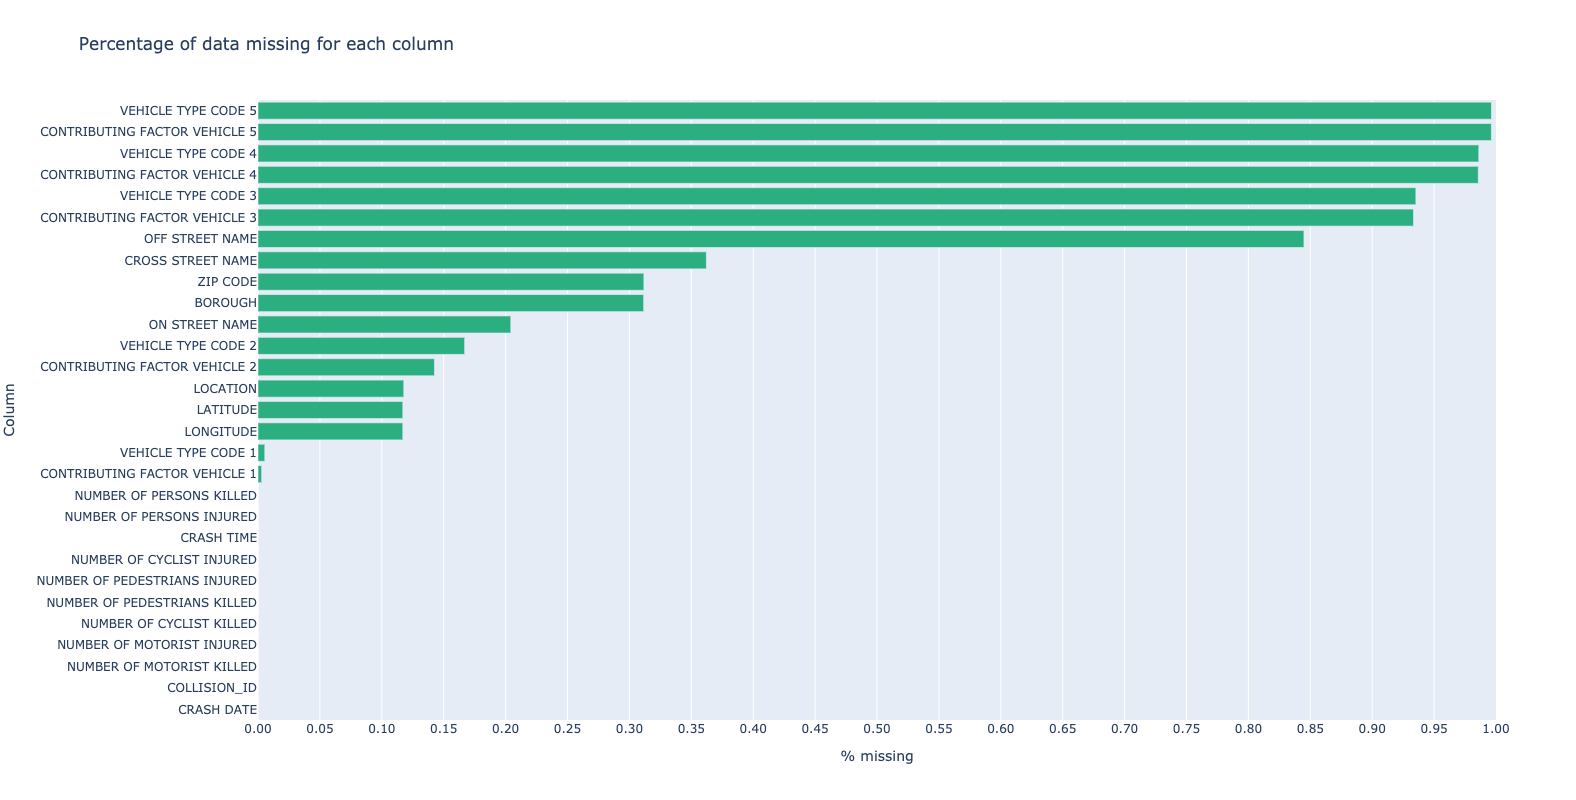

In [4]:
missing_pct_df = pd.DataFrame((df.isnull().sum(axis=0)/len(df)).sort_values(ascending=True)).reset_index(); missing_pct_df.columns = ['Column', 'Percentage missing']

import plotly.express as px
fig = px.bar(missing_pct_df, x="Percentage missing", y="Column", orientation='h', width = 1000, height=800, title='Percentage of data missing for each column')
fig.update_layout(
    xaxis_title="% missing",
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1.05,0.05),
        ticktext = ['{0:.2f}'.format(x) for x in np.arange(0, 1.05, 0.05)]
    ),
    hoverlabel_font_color='White')
fig.update_xaxes(range=[0, 1], row=1, col=1)

fig.update_traces(
    marker_color='rgb(43,174,128)'
)

fig.show()

## Preprocessing - Part 2: *Cleaning up `LOCATION`, `LATITUDE` and `LONGITUDE`*

Firstly, the **11.7% of the observations** where `LOCATION` was missing were dropped. Then outliers in the location were removed by selecting an appropriate interval for latitudes and longitudes for New York, which is plotted below.

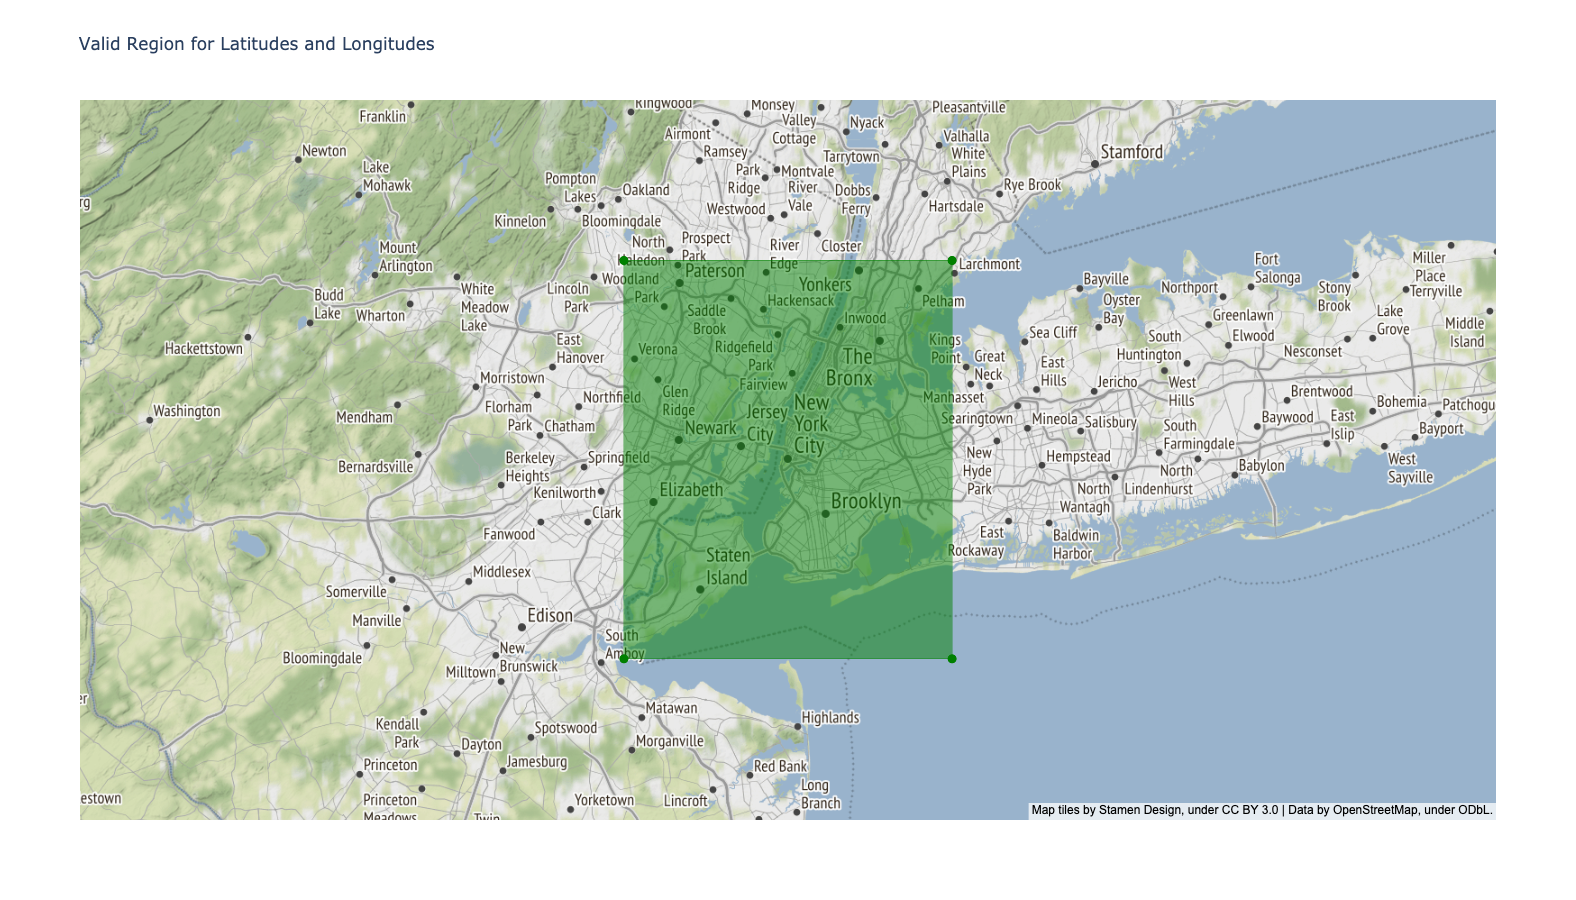

In [5]:
import plotly.graph_objects as go
lon_center = -74.006058
lat_center = 40.712772
lat_width = 0.23
lon_width  = 0.25

fig = go.Figure(go.Scattermapbox(
    fill = "toself",
    lon = [lon_center-lon_width, lon_center+lon_width, lon_center+lon_width, lon_center-lon_width], lat = [lat_center+lat_width, lat_center+lat_width, lat_center-lat_width, lat_center-lat_width],
    marker = { 'size': 10, 'color': "green" }))

fig.update_layout(
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -74.006058, 'lat': 40.712772},
        'zoom': 8.85},
    showlegend = False, width=1200, height=900, title='Valid Region for Latitudes and Longitudes')

fig.show()

#Drop rows where LOCATION is missing.
df = df.loc[~df['LOCATION'].isna()]

#Drop rows outside the green box below.
df = df.loc[(df['LONGITUDE'] >= lon_center - lon_width) & 
            (df['LONGITUDE'] <= lon_center + lon_width) & 
            (df['LATITUDE']  >= lat_center - lat_width) & 
            (df['LATITUDE'] <= lat_center + lat_width)]

## Preprocessing - Part 3: *Cleaning up `BOROUGH` and `ZIP CODE`*

In [53]:
(_, data_complete), (_, data_missing) = df.groupby(np.any(pd.isna(df[['ZIP CODE', 'BOROUGH']]), axis=1))

print(f'Number of rows with either ZIP or BOROUGH missing: {len(data_complete)}')
data_complete.head()

Number of rows with either ZIP or BOROUGH missing: 1059705


CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
199  12/28/2020      17:28      BRONX   10456.0  40.824066 -73.908714   
218  12/17/2020      14:43     QUEENS   11368.0  40.747650 -73.863010   
221  12/15/2020      11:00  MANHATTAN   10002.0  40.713920 -73.991714   
224  12/14/2020      17:11      BRONX   10459.0  40.820990 -73.895890   
236  12/08/2020      19:52   BROOKLYN   11229.0  40.599728 -73.937920   

                    LOCATION                    ON STREET NAME  \
199  (40.824066, -73.908714)  3 AVENUE                           
218    (40.74765, -73.86301)                               NaN   
221   (40.71392, -73.991714)                               NaN   
224    (40.82099, -73.89589)  KELLY STREET                       
236   (40.599728, -73.93792)                               NaN   

    CROSS STREET NAME                           OFF STREET NAME  \
199   EAST 163 STREET                                       NaN   
218               NaN  102-02    42 AVENUE                        
221               NaN  129       EAST BROADWAY                    
224   EAST 163 STREET                                       NaN   
236               NaN  2152      FORD STREET                      

     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
199                        0.0                       0.0   
218                        0.0                       0.0   
221                        0.0                       0.0   
224                        0.0                       0.0   
236                        0.0                       0.0   

     NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
199                              0                             0   
218                              0                             0   
221                              0                             0   
224                              0                             0   
236                              0                             0   

     NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
199                          0                         0   
218                          0                         0   
221                          0                         0   
224                          0                         0   
236                          0                         0   

     NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  \
199                           0                          0   
218                           0                          0   
221                           0                          0   
224                           0                          0   
236                           0                          0   

    CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
199                   Unspecified                   Unspecified   
218                   Unspecified                           NaN   
221                   Unspecified                           NaN   
224                   Unspecified                           NaN   
236                   Unspecified                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
199                           NaN                           NaN   
218                           NaN                           NaN   
221                           NaN                           NaN   
224                           NaN                           NaN   
236                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID     VEHICLE TYPE CODE 1  \
199                           NaN       4379833                   Sedan   
218                           NaN       4376945  Tractor Truck Gasoline   
221                           NaN       4376264                   Sedan   
224                           NaN       4376147                   Sedan   
236                           NaN       4374372                   Sedan   

    V

In [54]:
print(f'Number of rows with either ZIP or BOROUGH missing: {len(data_missing)}')
data_missing.head()

Number of rows with either ZIP or BOROUGH missing: 334840


CRASH DATE CRASH TIME BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
217  12/18/2020      21:55     NaN       NaN  40.695970 -73.913370   
232  12/11/2020      14:43     NaN       NaN  40.843246 -73.945050   
237  12/08/2020       2:00     NaN       NaN  40.865100 -73.921890   
238  12/07/2020      10:00     NaN       NaN  40.820827 -73.950836   
243  12/05/2020      13:45     NaN       NaN  40.651863 -73.865360   

                    LOCATION                    ON STREET NAME  \
217    (40.69597, -73.91337)  KNICKERBOCKER AVENUE               
232   (40.843246, -73.94505)  HENRY HUDSON PARKWAY               
237     (40.8651, -73.92189)  SHERMAN AVENUE                     
238  (40.820827, -73.950836)  WEST 138 STREET                    
243   (40.651863, -73.86536)  BELT PARKWAY                       

    CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  \
217               NaN             NaN                        0.0   
232               NaN             NaN                        0.0   
237               NaN             NaN                        0.0   
238               NaN             NaN                        0.0   
243               NaN             NaN                        1.0   

     NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
217                       0.0                              0   
232                       0.0                              0   
237                       0.0                              0   
238                       0.0                              0   
243                       0.0                              0   

     NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
217                             0                          0   
232                             0                          0   
237                             0                          0   
238                             0                          0   
243                             0                          0   

     NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
217                         0                           0   
232                         0                           0   
237                         0                           0   
238                         0                           0   
243                         0                           1   

     NUMBER OF MOTORIST KILLED CONTRIBUTING FACTOR VEHICLE 1  \
217                          0         Following Too Closely   
232                          0         Following Too Closely   
237                          0  Aggressive Driving/Road Rage   
238                          0                   Unspecified   
243                          0         Following Too Closely   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
217                   Unspecified                           NaN   
232                   Unspecified                           NaN   
237                   Unspecified                           NaN   
238                           NaN                           NaN   
243                   Unspecified                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
217                           NaN                           NaN       4377213   
232                           NaN                           NaN       4375744   
237                           NaN                           NaN       4374133   
238                           NaN                           NaN       4374340   
243                           NaN                           NaN       4373337   

    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
217               Sedan                                  NaN   
232               Sedan                                  NaN   
237               Sedan                                Sedan   
238               Sedan                                  NaN   
243               Sedan  Station Wagon/Sport U

Instead of discarding rows with `BOROUGH` or `ZIP CODE` missing, we want to impute it using **K-Nearest Neighbors**. We want to train our model on `data_complete` above, but we found that even in this data, there are some ambiguities with ZIP codes. 

In [55]:
counts = data_complete.groupby(['ZIP CODE', 'BOROUGH']).size().reset_index(); counts.columns = ['ZIP CODE', 'BOROUGH', 'COUNT']
zips, n = np.unique(counts['ZIP CODE'], return_counts=True)
counts.loc[counts['ZIP CODE'].apply(lambda x : x in zips[n > 1])]

ZIP CODE   BOROUGH  COUNT
140   11208.0  BROOKLYN  12337
141   11208.0    QUEENS    156
169   11237.0  BROOKLYN   6367
170   11237.0    QUEENS    280
201   11385.0  BROOKLYN     30
202   11385.0    QUEENS  13513
213   11421.0  BROOKLYN      6
214   11421.0    QUEENS   4208

Here, we can see that there is a total of **472 observations**, which we wish to correct such that ZIP codes belong to a borough. If we look up ZIP code [11208](https://www.unitedstateszipcodes.org/11208/), we can indeed see that the majority of the ZIP code lies within Brooklyn (which is also reflected in the large majority of them being borough Brooklyn in the table above). We fix this by assigning each ZIP code according to the majority. **Note: This gives us a mapping from ZIP code to Borough. We can therefore impute `ZIP CODE` using KNN, and then map from `ZIP CODE` to `BOROUGH` using our majority-vote system.**

In [56]:
#We make a mapping between zip code and the correct borough.
zip_to_borough = {}
for zip_, subset in counts.groupby('ZIP CODE'): zip_to_borough[zip_] = subset.sort_values('COUNT', ascending=False)['BOROUGH'].iloc[0]

#Let us look at a few examples of our remapping.
pd.DataFrame(zip_to_borough.items(), columns=['From', 'To']).sample(frac=1).head() #.sample(frac=1) just shuffles it so we can look at a few different ones.

From         To
192  11372.0     QUEENS
141  11209.0   BROOKLYN
190  11369.0     QUEENS
106  10458.0      BRONX
38   10040.0  MANHATTAN

In [57]:
remapped_boroughs = data_complete['ZIP CODE'].replace(zip_to_borough)
n_remaps = (remapped_boroughs != data_complete['BOROUGH']).sum()
print(f'{n_remaps} boroughs were remapped.')
data_complete['BOROUGH'] = remapped_boroughs

472 boroughs were remapped.


### K-Nearest-Neighbor Imputation of the ZIP code

For the locations with missing **ZIP code** but not missing **location** (334840 observations in total), the ZIP code was imputed using a KNN classifier using k=3 nearest neighbors. The zip code could then be mapped to the borough using majority voting as was discussed previously. As seen below, the classification of borough was fairly succesful, which meant that a lot of data that otherwise had been discarded was used.

In [61]:
le = LabelEncoder()

Xtrain = data_complete[['LATITUDE', 'LONGITUDE']].values
ytrain = le.fit_transform(data_complete['ZIP CODE'].to_numpy())

clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(Xtrain,ytrain)

Ximpute = data_missing[['LATITUDE', 'LONGITUDE']].values
yimpute = le.inverse_transform(clf.predict(Ximpute))

Before imputing `BOROUGH` and `ZIP CODE` in `data_missing`:

In [62]:
data_missing.head()

CRASH DATE CRASH TIME BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
217  12/18/2020      21:55     NaN       NaN  40.695970 -73.913370   
232  12/11/2020      14:43     NaN       NaN  40.843246 -73.945050   
237  12/08/2020       2:00     NaN       NaN  40.865100 -73.921890   
238  12/07/2020      10:00     NaN       NaN  40.820827 -73.950836   
243  12/05/2020      13:45     NaN       NaN  40.651863 -73.865360   

                    LOCATION                    ON STREET NAME  \
217    (40.69597, -73.91337)  KNICKERBOCKER AVENUE               
232   (40.843246, -73.94505)  HENRY HUDSON PARKWAY               
237     (40.8651, -73.92189)  SHERMAN AVENUE                     
238  (40.820827, -73.950836)  WEST 138 STREET                    
243   (40.651863, -73.86536)  BELT PARKWAY                       

    CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  \
217               NaN             NaN                        0.0   
232               NaN             NaN                        0.0   
237               NaN             NaN                        0.0   
238               NaN             NaN                        0.0   
243               NaN             NaN                        1.0   

     NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
217                       0.0                              0   
232                       0.0                              0   
237                       0.0                              0   
238                       0.0                              0   
243                       0.0                              0   

     NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
217                             0                          0   
232                             0                          0   
237                             0                          0   
238                             0                          0   
243                             0                          0   

     NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
217                         0                           0   
232                         0                           0   
237                         0                           0   
238                         0                           0   
243                         0                           1   

     NUMBER OF MOTORIST KILLED CONTRIBUTING FACTOR VEHICLE 1  \
217                          0         Following Too Closely   
232                          0         Following Too Closely   
237                          0  Aggressive Driving/Road Rage   
238                          0                   Unspecified   
243                          0         Following Too Closely   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
217                   Unspecified                           NaN   
232                   Unspecified                           NaN   
237                   Unspecified                           NaN   
238                           NaN                           NaN   
243                   Unspecified                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
217                           NaN                           NaN       4377213   
232                           NaN                           NaN       4375744   
237                           NaN                           NaN       4374133   
238                           NaN                           NaN       4374340   
243                           NaN                           NaN       4373337   

    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
217               Sedan                                  NaN   
232               Sedan                                  NaN   
237               Sedan                                Sedan   
238               Sedan                                  NaN   
243               Sedan  Station Wagon/Sport U

After imputing `BOROUGH` and `ZIP CODE` in `data_missing`: 

In [63]:
data_missing['ZIP CODE'] = yimpute
data_missing['BOROUGH']  = data_missing['ZIP CODE'].replace(zip_to_borough)
data_missing.head()

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
217  12/18/2020      21:55   BROOKLYN   11221.0  40.695970 -73.913370   
232  12/11/2020      14:43  MANHATTAN   10032.0  40.843246 -73.945050   
237  12/08/2020       2:00  MANHATTAN   10034.0  40.865100 -73.921890   
238  12/07/2020      10:00  MANHATTAN   10031.0  40.820827 -73.950836   
243  12/05/2020      13:45   BROOKLYN   11234.0  40.651863 -73.865360   

                    LOCATION                    ON STREET NAME  \
217    (40.69597, -73.91337)  KNICKERBOCKER AVENUE               
232   (40.843246, -73.94505)  HENRY HUDSON PARKWAY               
237     (40.8651, -73.92189)  SHERMAN AVENUE                     
238  (40.820827, -73.950836)  WEST 138 STREET                    
243   (40.651863, -73.86536)  BELT PARKWAY                       

    CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  \
217               NaN             NaN                        0.0   
232               NaN             NaN                        0.0   
237               NaN             NaN                        0.0   
238               NaN             NaN                        0.0   
243               NaN             NaN                        1.0   

     NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
217                       0.0                              0   
232                       0.0                              0   
237                       0.0                              0   
238                       0.0                              0   
243                       0.0                              0   

     NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
217                             0                          0   
232                             0                          0   
237                             0                          0   
238                             0                          0   
243                             0                          0   

     NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
217                         0                           0   
232                         0                           0   
237                         0                           0   
238                         0                           0   
243                         0                           1   

     NUMBER OF MOTORIST KILLED CONTRIBUTING FACTOR VEHICLE 1  \
217                          0         Following Too Closely   
232                          0         Following Too Closely   
237                          0  Aggressive Driving/Road Rage   
238                          0                   Unspecified   
243                          0         Following Too Closely   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
217                   Unspecified                           NaN   
232                   Unspecified                           NaN   
237                   Unspecified                           NaN   
238                           NaN                           NaN   
243                   Unspecified                   Unspecified   

    CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
217                           NaN                           NaN       4377213   
232                           NaN                           NaN       4375744   
237                           NaN                           NaN       4374133   
238                           NaN                           NaN       4374340   
243                           NaN                           NaN       4373337   

    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
217               Sedan                                  NaN   
232               Sedan                                  NaN   
237               Sedan                                Sedan   
238               Sedan                                  NaN   
243               Sedan  Sta

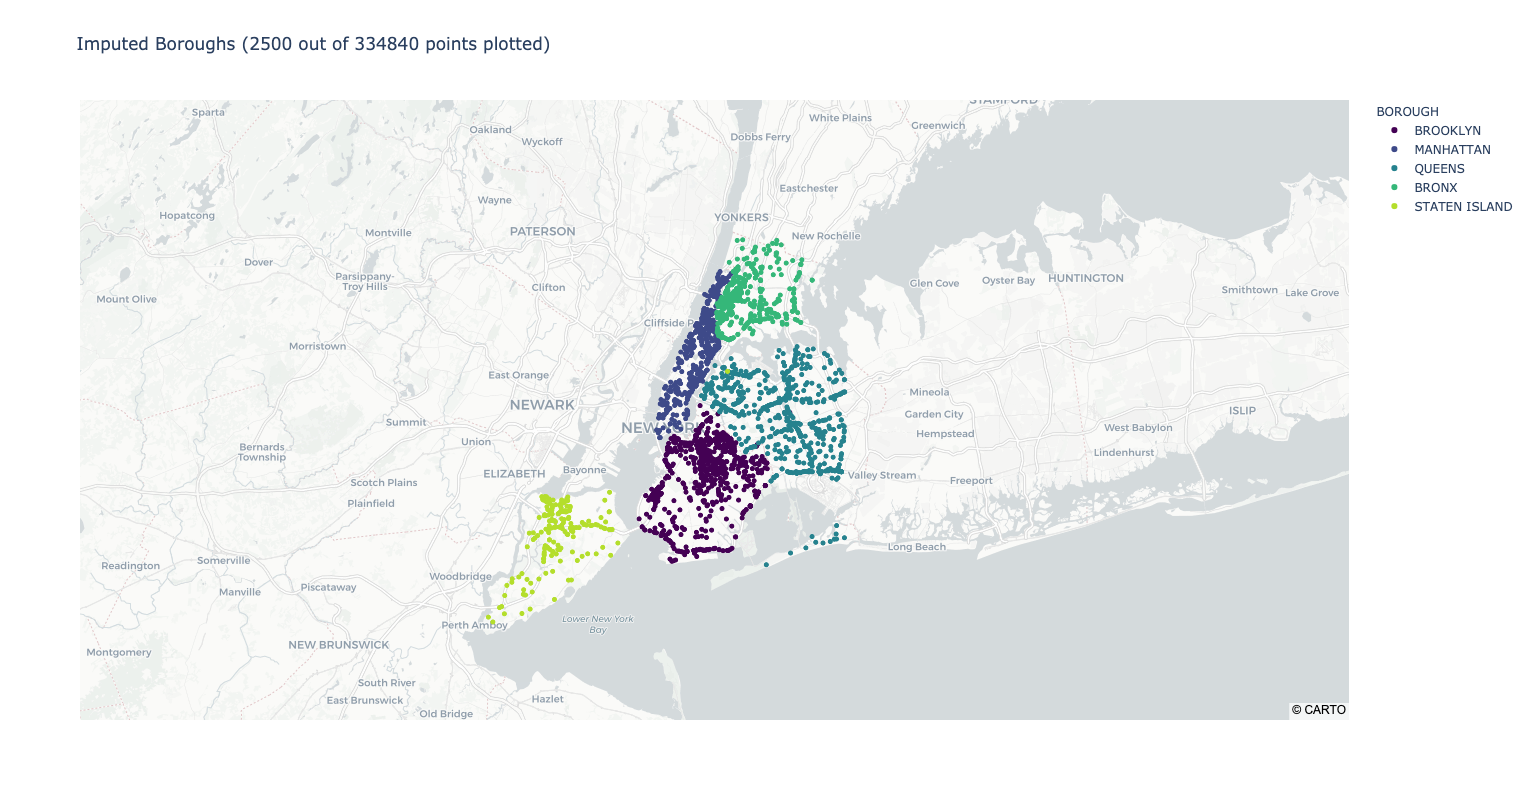

In [66]:
fig = px.scatter_mapbox(data_missing[:2500], lat='LATITUDE', lon='LONGITUDE', color='BOROUGH',
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="carto-positron",
                        width = 800, height = 800, title='Imputed Boroughs (2500 out of 334840 points plotted)',
                        color_discrete_sequence=['#440154', '#3e4a89','#26828e','#35b779','#b4de2c'])

fig.show()

In [73]:
df = data_complete.append(data_missing)
df.head()

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
199  12/28/2020      17:28      BRONX   10456.0  40.824066 -73.908714   
218  12/17/2020      14:43     QUEENS   11368.0  40.747650 -73.863010   
221  12/15/2020      11:00  MANHATTAN   10002.0  40.713920 -73.991714   
224  12/14/2020      17:11      BRONX   10459.0  40.820990 -73.895890   
236  12/08/2020      19:52   BROOKLYN   11229.0  40.599728 -73.937920   

                    LOCATION                    ON STREET NAME  \
199  (40.824066, -73.908714)  3 AVENUE                           
218    (40.74765, -73.86301)                               NaN   
221   (40.71392, -73.991714)                               NaN   
224    (40.82099, -73.89589)  KELLY STREET                       
236   (40.599728, -73.93792)                               NaN   

    CROSS STREET NAME                           OFF STREET NAME  \
199   EAST 163 STREET                                       NaN   
218               NaN  102-02    42 AVENUE                        
221               NaN  129       EAST BROADWAY                    
224   EAST 163 STREET                                       NaN   
236               NaN  2152      FORD STREET                      

     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
199                        0.0                       0.0   
218                        0.0                       0.0   
221                        0.0                       0.0   
224                        0.0                       0.0   
236                        0.0                       0.0   

     NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
199                              0                             0   
218                              0                             0   
221                              0                             0   
224                              0                             0   
236                              0                             0   

     NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  \
199                          0                         0   
218                          0                         0   
221                          0                         0   
224                          0                         0   
236                          0                         0   

     NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  \
199                           0                          0   
218                           0                          0   
221                           0                          0   
224                           0                          0   
236                           0                          0   

    CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
199                   Unspecified                   Unspecified   
218                   Unspecified                           NaN   
221                   Unspecified                           NaN   
224                   Unspecified                           NaN   
236                   Unspecified                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
199                           NaN                           NaN   
218                           NaN                           NaN   
221                           NaN                           NaN   
224                           NaN                           NaN   
236                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID     VEHICLE TYPE CODE 1  \
199                           NaN       4379833                   Sedan   
218                           NaN       4376945  Tractor Truck Gasoline   
221                           NaN       4376264                   Sedan   
224                           NaN       4376147                   Sedan   
236                           NaN       4374372                   Sedan   

    V

## Preprocessing - Part 4: *Encoding Contributing Factors* 

First, we want to fill `NaN`s in `CONTRIBUTING FACTOR VEHICLE 1` with "Unspecified".  

In [88]:
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unspecified')

In [89]:
df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15]

CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
280                   Unspecified                           NaN   
291                   Unspecified                           NaN   
317       View Obstructed/Limited                           NaN   
323                   Unspecified                   Unspecified   
339              Backing Unsafely                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
280                           NaN                           NaN   
291                           NaN                           NaN   
317                           NaN                           NaN   
323                           NaN                           NaN   
339                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  
280                           NaN  
291                           NaN  
317                           NaN  
323                           NaN  
339                           NaN

The used encoding is shown below:

In [90]:
encoded = pd.DataFrame({'CF_Unspecified' : df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].apply(lambda x : 'Unspecified' in list(x), axis=1).astype(int),
                        'CF_Driver Backing Unsafely' : df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].apply(lambda x : 'Backing Unsafely' in list(x), axis=1).astype(int),
                        'CF_View Obstructed/Limited' : df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].apply(lambda x : 'View Obstructed/Limited' in list(x), axis=1).astype(int)})

df[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]].iloc[10:15].join(encoded)

CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
280                   Unspecified                           NaN   
291                   Unspecified                           NaN   
317       View Obstructed/Limited                           NaN   
323                   Unspecified                   Unspecified   
339              Backing Unsafely                           NaN   

    CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4  \
280                           NaN                           NaN   
291                           NaN                           NaN   
317                           NaN                           NaN   
323                           NaN                           NaN   
339                           NaN                           NaN   

    CONTRIBUTING FACTOR VEHICLE 5  CF_Unspecified  CF_Driver Backing Unsafely  \
280                           NaN               1                           0   
291                           NaN               1                           0   
317                           NaN               0                           0   
323                           NaN               1                           0   
339                           NaN               0                           1   

     CF_View Obstructed/Limited  
280                           0  
291                           0  
317                           1  
323                           0  
339                           0

where e.g. `CF_Backing Unsafely = 1` indicates that one of the contributing factors was labeled as "Backing Unsafely". This means that we will add quite a lot of new columns since we have quite a lot of contributing factors.

In [92]:
unique_factors = np.unique(df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values.reshape(-1,).astype(str))
print(f'Number of unique factors: {len(unique_factors)}')

Number of unique factors: 62


### Other Funky Rows

During the data preperation, some special cases worth mentioning were also found:
- 11 rows were discarded due to `NUMBER OF PERSONS KILLED` not matching `NUMBER OF PEDESTRIANS KILLED`, `NUMBER OF CYCLISTS KILLED` and `NUMBER OF MOTORIST KILLED`. 
- Likewise, 534 rows were discarded due to `NUMBER OF PERSONS INJURED` not matching `NUMBER OF PEDESTRIANS INJURED`, `NUMBER OF CYCLISTS INJURED` and `NUMBER OF MOTORIST INJURED`.

### Dependencies

Here, we load all of the dependencies.

# Data Analysis

We need to normalize the data 

# Genre

This section will look into the specific genre and tools used to create a narrative data story (cf. Narrative Visualization: Telling Stories with Data, by Edward Segel and Jeffrey Heer figure 7), but also our goals for the end user's experience. 

The first item from Segal and Heer, that we will analyze is the of *genre* in our story telling. We set the scene for the website as a *pasistioned poster* to easily guide the reader trough the main story, but without having a strict linear progression. Our intened audience for the website are data-interested, who too are curious about data from NYC motor vehicle collisions, but without any speficific data analytic background. The goal for the end user's experience should be that, they feel that they have learned something new, but importantly is that they have had the opperitunity of exploring on their own as well. We have given the users the ability to explore on it's own by also including a *slide show* with three different sub-topics, where the reader can get additional information on topics of interest. The slide show is chosen to maintain a certain professionalism. Below we will give an (elaborated) argumentation of the chosen sub-topic:

1. How alcohol involvement are a contributing factor of motor vehicle collions. 
2. How texting or calling from the phone while driving are  a contributing factor of motor vehicle collions. 
3. How Covid-19 has had an affect the motor vehicle collions in NYC.

As we a trying to achieve the goal from Vison Zero, it made sence to look into the awareness campaignes made the last seven years. We found many interesting campaigns targeted directly at awareness of driving while influenced by alcohol and driving while texting or calling from the phone was found.  The campagin "Choices" from March 2016 (http://www.nyc.gov/html/visionzero/pages/initiatives/choices.shtml), had a clear message: Choose not to drink and drive. Other campaigns like "Your Choice Matter" from October 2014 (http://www.nyc.gov/opt/iplanet/servers/cgi-bin/exit.pl?url=http://yourchoicesmatter.nyc) and a radio add "Was it worth it" from December 2019 (https://www1.nyc.gov/html/dot/html/about/campaigns.shtml) went for the awareness about distraction and hereby texting or calling while driving. Naturally we want to investigate these two contribuating factors, with the focus on collisions that ended in either injuries or death. <br>
The last of the three sub-topics is the influence of the world pandamic Covid-19, and esspecially how it has affected the motor vehicle collions in NYC, when most citizen have been in lockdown or worked from home.  

The second point from Segal and Heer is the use of *visual narrative* tools. Looking at the *visual structering* first, we have mostly used the *consistent visual platform*, where plots are more or less displayed in the same size. One of our goals with our visualization was that it could stand alone and be self-explanatory, and one could therefor say that the visual structure resemble the *Splash Screen*.  <br>
With each visualization we want to build on our narrative data story, and some the ways we have *highlighted* important finding are with *zooming* and *motion*, for instance in the geo-plot, where the reader can move map and zoom in and out to it's liking. This emphasises our goal, that the reader can explore additional findings beyond our primary scope. <br>
We have 

The last element from Segal and Heer that we will discuss is the element of *narrative structure*. As we mentioned before, we want to easily guide the reader without a strict linear progression. What we mean by that is, the overall structure follows a *linear* progression with the introduction, sub-topics and final i summary, however in the three sub-topics we want to give the user a *user directed path* to explore on their own. <br>
*Interactivity* is a very important element to reach our goal for the end user's experience of self-exploration. We have therefor included multiple items such as details on demand with a *hover highlighting, filter* and *navigation bottons*. WRITE ABOUT EXPLICIT OR TACIT INSTRUCTION!! <br>
The final part for this section deal with *messaging*. Just like we talked about in visual narrative, we want the visualizations to be self-explanatory. We done that be including *captions* and *annotations* in every visualization included. Naturally, we written a introduction in the beginning of each section, and likewise a summary in the end. 

# Visualizations 
In the section below we will explain the visualizations, we have chosen to display on the website. 

# Discussion

What went well?

What is still missing? What could be improved? Why?
We could have looked more into these contributing factor or vehical type 

# Contributions